In [29]:
import torch
import numpy as np
from torch.utils.data import DataLoader, Dataset
import torch.nn
import torch.nn.functional as F
import os
import pandas as pd
from sklearn.model_selection import train_test_split
from transformers import DistilBertTokenizerFast
from transformers import DistilBertModel, DistilBertConfig

In [ ]:
!wget https://ai.stanford.edu/~amaas/data/sentiment/aclImdb_v1.tar.gz
!tar -xf aclImdb_v1.tar.gz

In [30]:
def generate_csv(data):
    data_dir = 'aclImdb'
    train_dir = data_dir + '/' + data
    train_neg = train_dir + '/neg'
    train_pos = train_dir + '/pos'
    negative_train_data = []
    for f_name in os.listdir(train_neg):
        with open(train_neg + "/" + f_name) as f:
            review = f.readlines()
            assert len(review) == 1
        negative_train_data.append(review[0])
    positive_train_data = []
    for f_name in os.listdir(train_pos):
        with open(train_pos + "/" + f_name) as f:
            review = f.readlines()
            assert len(review) == 1
        positive_train_data.append(review[0])
    train_data = pd.DataFrame(data=positive_train_data, columns=['review'])
    positives = [1 for _ in range(len(positive_train_data))]
    train_data['sentiment'] = positives
    train_neg = pd.DataFrame(data=negative_train_data, columns=['review'])
    negatives = [0 for _ in range(len(negative_train_data))]
    train_neg['sentiment'] = negatives
    train_data = pd.concat([train_data, train_neg])
    new_ind = pd.Index(range(len(negative_train_data) + len(positive_train_data)))
    train_data = train_data.set_index(new_ind)
    return train_data

In [31]:
train_df = generate_csv('train')
test_df = generate_csv('test')

In [33]:
from bs4 import BeautifulSoup
import re
from nltk.corpus import stopwords
import string

stop = stopwords.words('english')
punctuation = list(string.punctuation)
stop += punctuation

def strip_html(text):
    soup = BeautifulSoup(text, "html.parser")
    return soup.get_text()


#Removing the square brackets
def remove_between_square_brackets(text):
    return re.sub('\[[^]]*\]', '', text)


# Removing URL's
def remove_between_square_brackets(text):
    return re.sub(r'http\S+', '', text)


#Removing the stopwords from text
def remove_stopwords(text):
    final_text = []
    for i in text.split():
        if i.strip().lower() not in stop and i.strip().lower().isalpha():
            final_text.append(i.strip().lower())
    return " ".join(final_text)


#Removing the noisy text
def denoise_text(text):
    text = strip_html(text)
    text = remove_between_square_brackets(text)
    text = remove_stopwords(text)
    return text


#Apply function on review column
train_df['review'] = train_df['review'].apply(denoise_text)
test_df['review'] = test_df['review'].apply(denoise_text)

/home/nikita/anaconda3/lib/python3.9/site-packages/bs4/__init__.py:435: MarkupResemblesLocatorWarning: The input looks more like a filename than markup. You may want to open this file and pass the filehandle into Beautiful Soup.
  warnings.warn(


In [34]:
train_df.iloc[0]['review']

'zentropa much common third another film set among rubble postwar like much inventive camera innocent american gets emotionally involved woman really whose naivety striking contrast say third man zentropa bit disjointed perhaps presented making coherent would spoil movie unrelentingly one one never sees sun'

In [41]:
train_df = train_df.sample(frac=1).reset_index()
test_df = test_df.sample(frac=1).reset_index()

In [42]:
test_df, val_df = train_test_split(test_df, test_size=0.2)

In [43]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
device

device(type='cuda')

In [44]:
tokenizer = DistilBertTokenizerFast.from_pretrained('distilbert-base-uncased')

In [45]:
MAX_LENGTH = 256


def batch_encode(tokenizer, texts, batch_size=16, max_length=MAX_LENGTH):
    input_ids = []
    attention_mask = []

    for i in range(0, len(texts), batch_size):
        batch = texts[i:i + batch_size]
        inputs = tokenizer.batch_encode_plus(batch,
                                             max_length=max_length,
                                             padding='max_length',
                                             truncation=True,
                                             return_attention_mask=True,
                                             return_token_type_ids=False
                                             )
        input_ids.extend(inputs['input_ids'])
        attention_mask.extend(inputs['attention_mask'])

    return torch.tensor(input_ids), torch.tensor(attention_mask)

In [46]:
X_train_ids, X_train_attn = batch_encode(tokenizer, train_df['review'].to_list())
X_test_ids, X_test_attn = batch_encode(tokenizer, test_df['review'].to_list())
X_val_ids, X_val_attn = batch_encode(tokenizer, val_df['review'].to_list())

In [47]:
y_train = torch.tensor(train_df['sentiment'].values)
y_test = torch.tensor(test_df['sentiment'].values)
y_val = torch.tensor(val_df['sentiment'].values)

In [48]:
DISTILBERT_DROPOUT = 0.2
DISTILBERT_ATT_DROPOUT = 0.2

# Configure DistilBERT's initialization
config = DistilBertConfig(dropout=DISTILBERT_DROPOUT,
                          attention_dropout=DISTILBERT_ATT_DROPOUT,
                          output_hidden_states=True)

# The bare, pre-trained DistilBERT transformer model outputting raw hidden-states
# and without any specific head on top.
distilBERT = DistilBertModel.from_pretrained('distilbert-base-uncased', config=config).to(device)

# Make DistilBERT layers untrainable
for param in distilBERT.parameters():
    param.requires_grad = False

Some weights of the model checkpoint at distilbert-base-uncased were not used when initializing DistilBertModel: ['vocab_layer_norm.bias', 'vocab_layer_norm.weight', 'vocab_transform.weight', 'vocab_transform.bias', 'vocab_projector.bias', 'vocab_projector.weight']
- This IS expected if you are initializing DistilBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [49]:
import tqdm


class TorchModel(torch.nn.Module):
    def __init__(self, transformer):
        super(TorchModel, self).__init__()
        self.fc1 = torch.nn.Linear(768, 1)
        self.transformer = transformer
        self.sigmoid = torch.sigmoid

    def forward(self, x):
        ids = x[0]
        attn = x[1]
        last_hidden_state = self.transformer(ids, attention_mask=attn)[0]
        cls_token = last_hidden_state[:, 0, :]
        x = self.fc1(cls_token)
        x = self.sigmoid(x)
        return x


torch_model = TorchModel(distilBERT).to(device)

loss = torch.nn.BCELoss()
learning_rate = 2e-5
optimizer = torch.optim.Adam(torch_model.parameters(), lr=learning_rate)
BATCH_SIZE = 16


def train_epoch(model, optim, loss_function, x_ids, x_attn, y):
    total_loss = 0
    accurate_pred = 0
    model.train()
    for i in tqdm.tqdm(range(0, len(x_ids), BATCH_SIZE)):
        ids = x_ids[i:i + BATCH_SIZE]
        attn = x_attn[i:i + BATCH_SIZE]
        y_batch = y[i:i + BATCH_SIZE]
        y_batch = y_batch.view(-1, 1)
        optim.zero_grad()
        y_pred = model([ids, attn])
        loss_val = loss_function(y_pred, y_batch.float())
        loss_val.backward()
        optim.step()
        total_loss += loss_val.item()
        accurate_pred += (y_pred.round() == y_batch.float()).sum().item()
    return total_loss / len(x_ids), accurate_pred / len(x_ids)


def val_epoch(model, loss_function, x_ids, x_attn, y):
    total_loss = 0
    accurate_pred = 0
    model.eval()
    for i in tqdm.tqdm(range(0, len(x_ids), BATCH_SIZE)):
        ids = x_ids[i:i + BATCH_SIZE]
        attn = x_attn[i:i + BATCH_SIZE]
        y_batch = y[i:i + BATCH_SIZE]
        y_batch = y_batch.view(-1, 1)
        y_pred = model([ids, attn])
        loss_val = loss_function(y_pred, y_batch.float())
        total_loss += loss_val.item()
        accurate_pred += (y_pred.round() == y_batch.float()).sum().item()
    return total_loss / len(x_ids), accurate_pred / len(x_ids)

In [51]:
EPOCHS = 6
for epoch in range(EPOCHS):
    train_loss, train_acc = train_epoch(torch_model, optimizer, loss, X_train_ids.to(device), X_train_attn.to(device), y_train.to(device))
    val_loss, val_acc = val_epoch(torch_model, loss, X_val_ids.to(device), X_val_attn.to(device), y_val.to(device))
    print(f'Epoch: {epoch + 1:02}')
    print(f'\tTrain Loss: {train_loss:.3f} | Train Acc: {train_acc * 100:.2f}%')
    print(f'\t Val. Loss: {val_loss:.3f} |  Val. Acc: {val_acc * 100:.2f}%')

100%|██████████| 282/282 [01:13<00:00,  3.83it/s]


Epoch: 01
	Train Loss: 0.042 | Train Acc: 62.12%
	 Val. Loss: 0.041 |  Val. Acc: 69.42%


100%|██████████| 282/282 [01:13<00:00,  3.82it/s]


Epoch: 02
	Train Loss: 0.041 | Train Acc: 69.26%
	 Val. Loss: 0.040 |  Val. Acc: 72.11%


100%|██████████| 282/282 [01:13<00:00,  3.82it/s]


Epoch: 03
	Train Loss: 0.040 | Train Acc: 71.29%
	 Val. Loss: 0.039 |  Val. Acc: 73.64%


100%|██████████| 282/282 [01:13<00:00,  3.82it/s]


Epoch: 04
	Train Loss: 0.039 | Train Acc: 72.38%
	 Val. Loss: 0.038 |  Val. Acc: 74.73%


100%|██████████| 282/282 [01:14<00:00,  3.80it/s]


Epoch: 05
	Train Loss: 0.038 | Train Acc: 72.86%
	 Val. Loss: 0.037 |  Val. Acc: 75.40%


100%|██████████| 282/282 [01:14<00:00,  3.76it/s]

Epoch: 06
	Train Loss: 0.038 | Train Acc: 73.82%
	 Val. Loss: 0.036 |  Val. Acc: 75.51%


In [105]:
torch.save(torch_model.state_dict(), 'torch_model.pt')

In [106]:
sample = ['I love this movie', 'I hate this movie']
ids, attn, = batch_encode(tokenizer, sample)
ids = ids.to(device)
attn = ids.to(device)
torch_model([ids, attn])
# torch_model(sample)

tensor([[0.6587],
        [0.4192]], device='cuda:0', grad_fn=<SigmoidBackward0>)

In [61]:
def get_train_predictions(model, loss_function, x_ids, x_attn, y):
    preds = []
    model.eval()
    with torch.no_grad():
        for i in tqdm.tqdm(range(0, len(x_ids), BATCH_SIZE)):
            ids = x_ids[i:i + BATCH_SIZE]
            attn = x_attn[i:i + BATCH_SIZE]
            y_batch = y[i:i + BATCH_SIZE]
            y_batch = y_batch.view(-1, 1)
            y_pred = model([ids, attn])
            preds.append(y_pred.to('cpu').detach().numpy())
    return preds

In [62]:
X_train_attn = X_train_attn.to(device)
X_train_ids = X_train_ids.to(device)
y_train = y_train.to(device)

In [63]:
preds = get_train_predictions(torch_model, loss, X_train_ids, X_train_attn, y_train)

100%|██████████| 1563/1563 [06:54<00:00,  3.77it/s]


In [64]:
preds = np.concatenate(preds)

<AxesSubplot:ylabel='Count'>

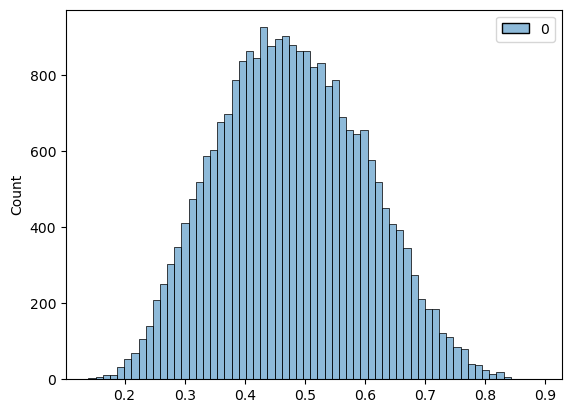

In [65]:
import seaborn as sns

sns.histplot(preds)

In [69]:
print('mean:', preds.mean())
print('min:', preds.min())
print('max:', preds.max())

mean: 0.47811675
min: 0.13989343
max: 0.8898689


In [70]:
val_epoch(torch_model, loss, X_test_ids.to(device), X_test_attn.to(device), y_test.to(device))

100%|██████████| 1125/1125 [04:53<00:00,  3.83it/s]


(0.03630903578301271, 0.7486111111111111)

In [90]:
sorted_preds = np.sort(preds, axis=None)
preds_10 = int(len(sorted_preds) * 0.1)

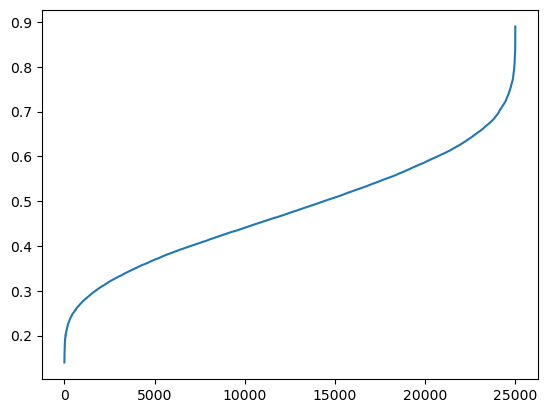

In [92]:
from matplotlib import pyplot as plt
plt.plot(sorted_preds)

In [93]:
score_quantile = []
for i in range(1, 10):
    score_quantile.append(sorted_preds[preds_10 * i])

def get_score(pred):
    for i, score in enumerate(score_quantile):
        if pred < score:
            return i + 1
    return 10

In [94]:
score_quantile

[0.32044193,
 0.3692736,
 0.40665343,
 0.44061545,
 0.4739672,
 0.5081665,
 0.5448841,
 0.5870045,
 0.6409643]

In [104]:
sample = ['']
ids, attn, = batch_encode(tokenizer, sample)
ids = ids.to(device)
attn = ids.to(device)
res = torch_model([ids, attn])
print(res.item())
get_score(res.item())

0.39627495408058167


3